# Load occupancy data: RC-60-Mix

In [1]:
import numpy as np 
import pandas as pd


In [2]:
root_folder = 'preprocessed_data/'
f_x = root_folder + '058_5p_to_1p_X.txt'
f_y = root_folder + '058_5p_to_1p_y.txt'
data = pd.read_csv(f_x, delimiter=' ', header = None)
labels = pd.read_csv(f_y, delimiter=' ', header = None)
print(data.shape, labels.shape)

(4340, 5976) (4340, 1)


In [3]:
#label 1: 5p
#label 2: 4p
#label 3: 3p
#label 4: 2p
#label 5: 1p

# RC-60-Mix: extract subdata by each label and produce 2d data

In [4]:
from utils.sampling import extract_car_data, generate_2d_data

In [5]:
def get_all_cars_2d(f_x, f_y, unique_labels, bin_length, stride, total_bin):
    aggregate_data = []
    aggregate_label = []
    for car_label in unique_labels:
        car_1d_data =  extract_car_data(f_x, f_y, car_label)
        car_2d_data, car_2d_label = generate_2d_data(car_1d_data, car_label, bin_length, stride, total_bin)
        aggregate_data.append(car_2d_data)
        aggregate_label.append(car_2d_label)
        
    return np.concatenate(aggregate_data,axis=0), np.concatenate(aggregate_label, axis=0)        

In [6]:
bin_length, stride = 6, 1
total_bin = None

In [7]:
unique_labels = [1, 2, 3, 4, 5]
aggregate_data, aggregate_label = get_all_cars_2d(f_x, f_y, unique_labels, bin_length, stride, total_bin)

In [8]:
aggregate_data.shape, aggregate_label.shape

((4310, 6, 5976), (4310,))

# Train 2d cnn on RC-60-Mix

In [9]:
from das_lib.models import cnn2d_dropout
from das_lib.funs import split_train_test_2d

2023-07-08 13:53:31.341681: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [10]:
from das_lib.funs import *
test_frac = .2
aggregate_data, aggregate_label = np.expand_dims(aggregate_data,-1), np.expand_dims(aggregate_label,-1)
y_one_hot = tf.keras.utils.to_categorical(aggregate_label-1, num_classes=5)
x_train, x_test, y_train, y_test, training_index = split_train_test_2d(aggregate_data, y_one_hot, test_frac)
m = cnn2d_dropout( (x_train.shape[1], x_train.shape[2],1), y_train.shape[1])
print(m.summary())

2023-07-08 13:54:06.325822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 13:54:08.610307: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:d8:00.0, compute capability: 8.0


Model: "1dcnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 5976, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 4, 5913, 16)       3088      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 739, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 739, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 724, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 90, 32)        0         
 2D)                                                   

In [11]:
x_test.shape, y_test.shape

((863, 6, 5976, 1), (863, 5))

In [12]:
H = m.fit(x_train, y_train, epochs=500, batch_size=64, validation_data=(x_test, y_test), verbose=False)
m.evaluate(x_test, y_test, batch_size=64, verbose=True)

2023-07-08 13:54:13.491400: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-07-08 13:54:19.478825: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


14/14 [==============================] - 0s 14ms/step - loss: 0.0134 - accuracy: 0.9316


[0.013364804908633232, 0.9316338300704956]

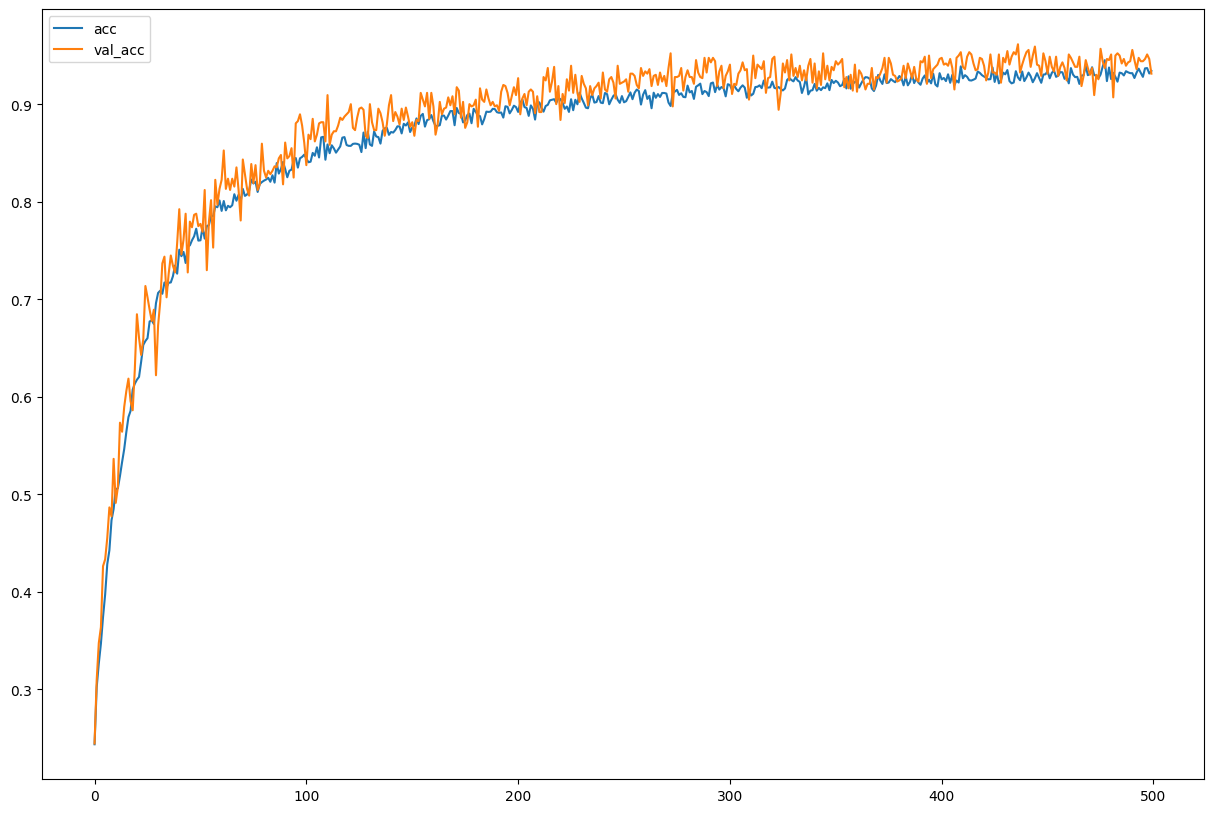

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))
plt.plot(H.history['accuracy'], label='acc')
plt.plot(H.history['val_accuracy'], label='val_acc')
plt.legend()

In [36]:
checkpoint_folder = 'training_results'
model_name = '5way_2d'
checkpoint_path = checkpoint_folder+'/'+'{0}'.format(model_name)
m.save(checkpoint_path)

INFO:tensorflow:Assets written to: training_results/5way_2d/assets


INFO:tensorflow:Assets written to: training_results/5way_2d/assets


In [ ]:
from das_lib.evaluation import save_training_history
f_name = 'performance/5way_2d.json'
save_training_history(f_name, H)

# Read the model

In [1]:
import tensorflow as tf
checkpoint_folder = 'training_results'
model_name = '5way_2d'
checkpoint_path = checkpoint_folder+'/'+'{0}'.format(model_name)
m = tf.keras.models.load_model(checkpoint_path)

2023-07-10 16:12:03.512670: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 16:12:33.895134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 16:12:36.143280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:2f:00.0, compute capability: 8.0


# Validate the trained model on Ind. RC-60-1p

In [12]:
from utils.sampling import extract_car_data, generate_2d_data
import numpy as np
root_folder = 'preprocessed_data/'
f_x = root_folder+'026_X.txt' 
f_y = root_folder+'026_y.txt'
car_label = 2 # in speed data (023-027), car 2 is label = 2
car2_data =  extract_car_data(f_x, f_y, car_label)

In [13]:
bin_length, stride, total_bin = 6, 1, None
car2_1p_data, car2_1p_label_old = generate_2d_data(car2_data, car_label, bin_length, stride, total_bin)

In [14]:
car2_1p_data.shape

(445, 6, 5976)

In [15]:
def expand_data(data, label):
    data= np.expand_dims(data,-1)
    label = np.array([label]*len(data))
    label = tf.keras.utils.to_categorical(label-1, num_classes=5)
    return data, label

In [16]:
label = 5 # in terms of occupancy, we have 1p driving car 2 => label = 5
car2_1p_data, car2_1p_label_new = expand_data(car2_1p_data, label)

In [17]:
car2_1p_data.shape, car2_1p_label_new.shape

((445, 6, 5976, 1), (445, 5))

In [19]:
results = m.evaluate(car2_1p_data, car2_1p_label_new)

14/14 [==============================] - 0s 6ms/step - loss: 0.0503 - accuracy: 0.6854


In [20]:
from das_lib.evaluation import save_wrong_indices
f_name = 'performance/wrong_indices/5way_2d_1p.json'
save_wrong_indices(f_name, m, car2_1p_data, car2_1p_label_new)

14/14 [==============================] - 0s 5ms/step


# Validate the trained mode on Ind. RC-60-5p

In [21]:
root_folder = 'preprocessed_data/'
f_x = root_folder+'058_5p_X.txt' 
f_y = root_folder+'058_5p_y.txt'
car_label = 1 #old label, direction west => label=1
car2_5p_data = extract_car_data(f_x, f_y, car_label)
car2_5p_data, car2_5p_label_old = generate_2d_data(car2_5p_data, car_label, bin_length, stride, total_bin)

In [22]:
label = 1 #new label, 5p in car 2 = > label = 1 
car2_5p_data, car2_5p_label_new = expand_data(car2_5p_data, label)

In [23]:
car2_5p_data.shape, car2_5p_label_new.shape

((285, 6, 5976, 1), (285, 5))

In [41]:
results = m.evaluate(car2_5p_data, car2_5p_label_new)

9/9 [==============================] - 0s 6ms/step - loss: 0.1319 - accuracy: 0.2842


In [25]:
f_name = 'performance/wrong_indices/5way_2d_5p.json'
save_wrong_indices(f_name, m, car2_5p_data, car2_5p_label_new)

9/9 [==============================] - 0s 4ms/step
